 ###  Butina Clustering Algorithm

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data.head()

,Unnamed: 0,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class
0,0,O=C1Nc2ccc(S(=O)(=O)Nc3ccc(O)c(Cl)c3)c3cccc1c23,CHEMBL3326305,42300.0,inactive
1,1,O=C1Sc2c(S(=O)(=O)Nc3ccc(O)cc3)cc(S(=O)(=O)Nc3...,CHEMBL3326315,14000.0,inactive
2,2,O=S(=O)(Nc1cc(Cl)c(O)c(Cl)c1)c1ccc2ccccc2c1,CHEMBL3356478,100000.0,inactive
3,3,O=S(=O)(Nc1ccc(O)c(Cl)c1)c1ccc(F)cc1,CHEMBL3314616,100000.0,inactive
4,4,Cc1cc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4...,CHEMBL3326318,20300.0,inactive


In [21]:
data.shape

(364, 5)

In [96]:
data = data.query("bioactivity_class == 'active'")

In [100]:
data.shape

(265, 5)

In [101]:
mols = []
for i in data.index:
    chemblid = data['molecule_chembl_id'][i]
    smiles = data['canonical_smiles'][i]
    mols.append((Chem.MolFromSmiles(smiles), chemblid))


In [102]:
mols[0:5]

[(<rdkit.Chem.rdchem.Mol at 0x2494a6840d0>, 'CHEMBL3640297'),
 (<rdkit.Chem.rdchem.Mol at 0x2494a684120>, 'CHEMBL3640298'),
 (<rdkit.Chem.rdchem.Mol at 0x2494a684170>, 'CHEMBL3640299'),
 (<rdkit.Chem.rdchem.Mol at 0x2494a6841c0>, 'CHEMBL3640300'),
 (<rdkit.Chem.rdchem.Mol at 0x2494a684210>, 'CHEMBL3640301')]

In [103]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m, indx in mols]

In [104]:
len(fingerprints)

265

In [105]:
def Tanimoto_distance_matrix (fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix    

In [106]:
len(Tanimoto_distance_matrix(fingerprints))

34980

In [107]:
def ClusterFps(fps, cutoff = 0.2):
    dist_mat = Tanimoto_distance_matrix (fps)
    clusters = Butina.ClusterData(dist_mat,len(fps),cutoff, isDistData=True)
    return clusters

In [108]:
clusters = ClusterFps(fingerprints, cutoff = 0.25)

In [109]:
len(clusters)

38

In [110]:
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  38
# clusters with only 1 compound:  15
# clusters with >5 compounds:  6
# clusters with >25 compounds:  2
# clusters with >100 compounds:  1


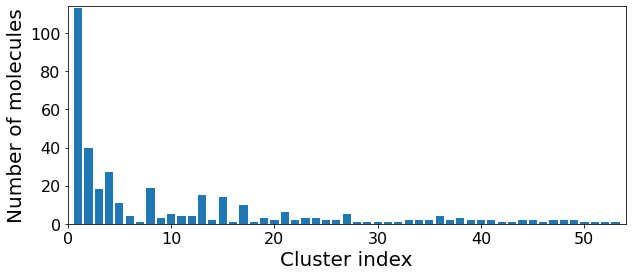

In [89]:
fig = plt.figure(1, figsize=(10, 4))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('Number of molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.show()

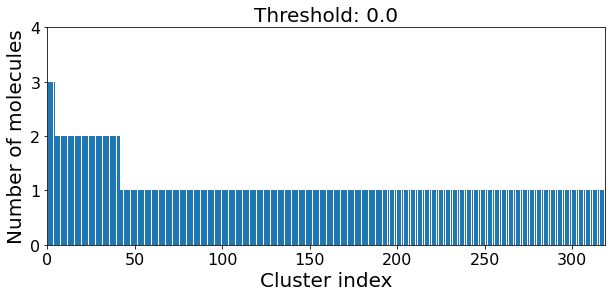

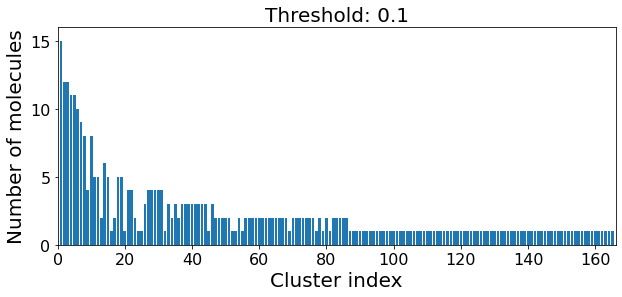

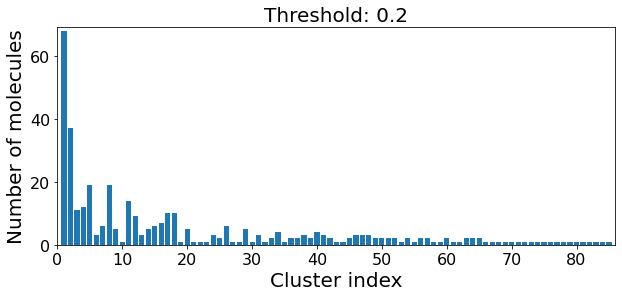

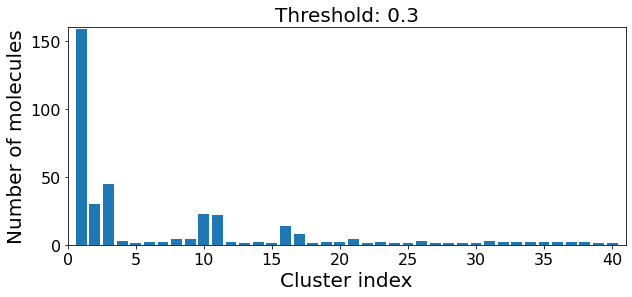

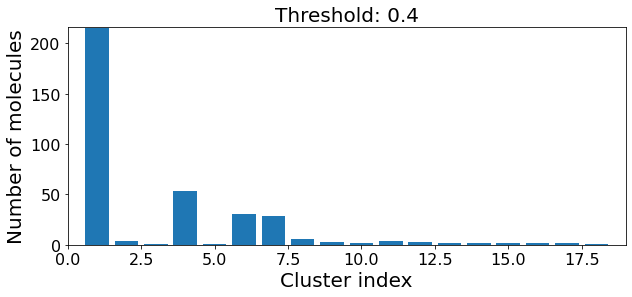

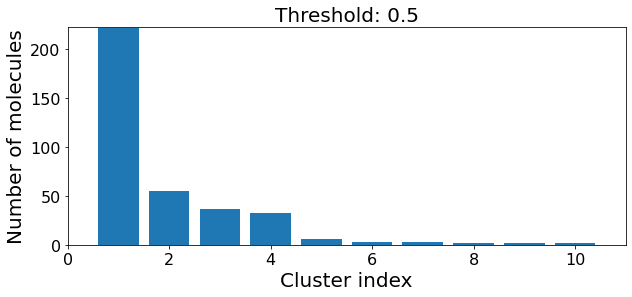

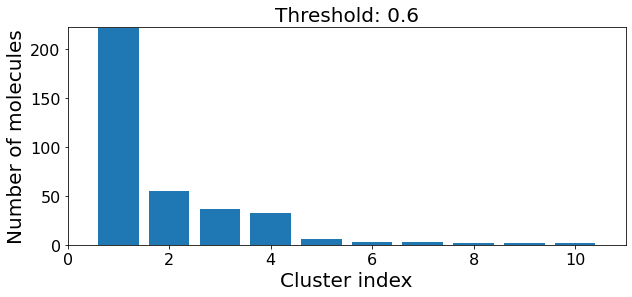

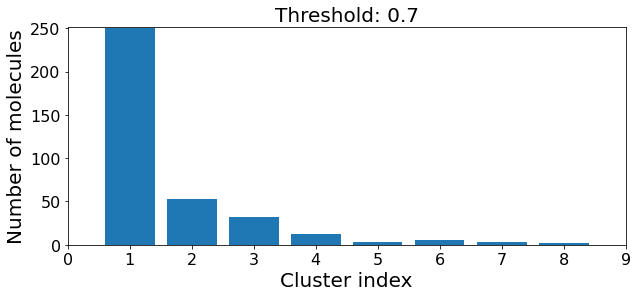

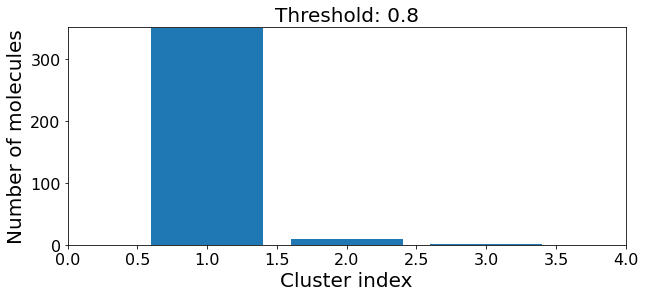

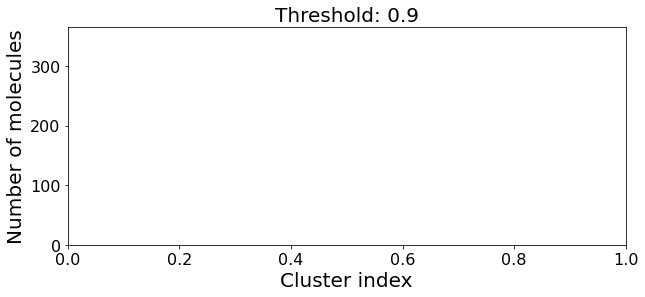

In [81]:
for i in numpy.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fingerprints,cutoff=i)
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %i), fontsize=20)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

In [111]:
len(clusters)

38

In [112]:
def IntraTanimoto(fps_clusters):
    intra_similarity =[]
    # Calculate intra similarity per cluster
    for k in range(0,len(fps_clusters)):
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1-x for x in Tanimoto_distance_matrix(fps_clusters[k])])
    return intra_similarity    

In [113]:
mol_fps_per_cluster=[]
for c in clusters[:5]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(mols[i][0]) for i in c])
# Compute intra-cluster similarity 
intra_sim = IntraTanimoto(mol_fps_per_cluster)

In [114]:
len(intra_sim)

5

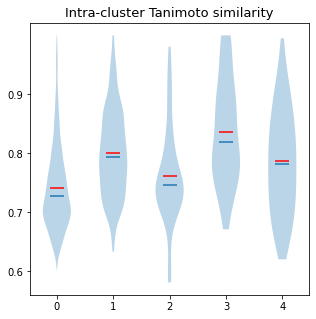

In [115]:
pos = list(range(5))
labels = pos
plt.figure(1, figsize=(5, 5))
ax = plt.subplot(111)
r = plt.violinplot(intra_sim, pos, showmeans=True, showmedians=True, showextrema=False)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0.6, 1., 0.1))
ax.set_title('Intra-cluster Tanimoto similarity', fontsize=13)
r['cmeans'].set_color('red')

five molecules from first 5 clusters:


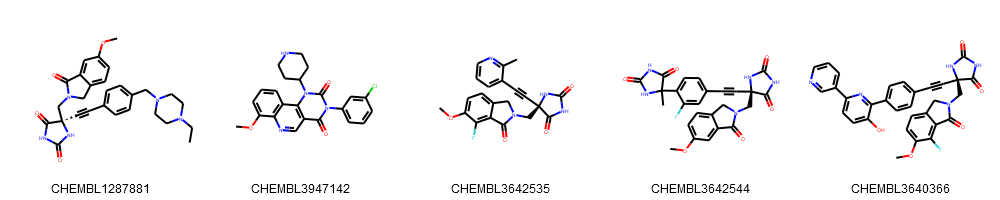

In [117]:
print ('five molecules from first 5 clusters:')
# Draw molecules
Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(5)], 
                     legends=[mols[clusters[i][0]][1] for i in range(10)], 
                     molsPerRow=5)